## SETUP

In [2]:
import numpy as np
from numpy.fft import fft2, ifft2
import scipy as sp
import sigpy
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import pywt

c:\Users\greno\Documents\Prog\MATH221\ma221_proj\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


kspace: (8, 230, 180) complex64


EspiritCalib: 100%|██████████| 100/100 [00:00<00:00, 121.33it/s]


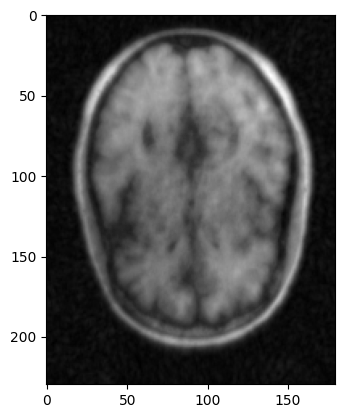

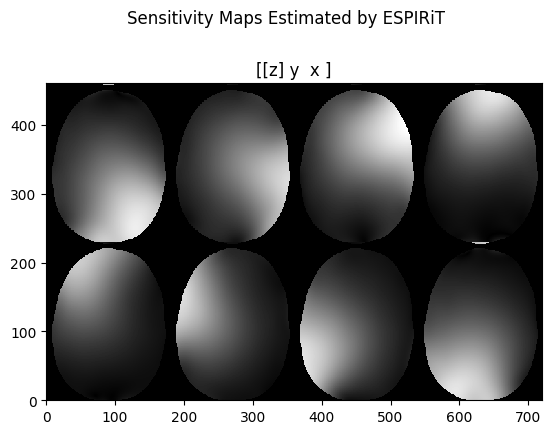

Sensitivity maps: (8, 230, 180) complex64


In [3]:
ksp_path = "../sigpy-mri-tutorial/data/"
ksp = np.load(ksp_path + 'cartesian_ksp.npy')
print('kspace:', ksp.shape, ksp.dtype)



img_mc = np.abs(sigpy.ifft(ksp, axes=(-1, -2))) # image space multicoil
img_rss = np.sum(img_mc**2, axis=0)**0.5
plt.imshow(img_rss, cmap='gray')

# get smaps
mps = mr.app.EspiritCalib(ksp).run()
pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
print('Sensitivity maps:', mps.shape, mps.dtype)

# Sigpy L1 Wavelet reconstruction

L1WaveletRecon: 100%|██████████| 100/100 [00:03<00:00, 29.18it/s, resid=8.58E-03]


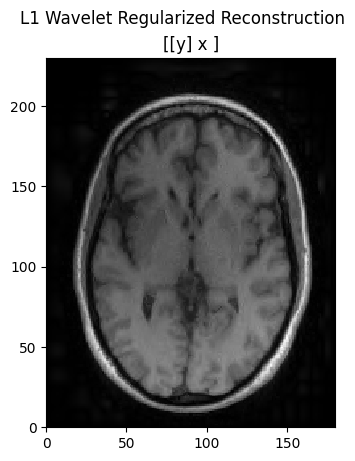

SenseRecon: 100%|██████████| 10/10 [00:00<00:00, 33.32it/s, resid=1.35E-01]


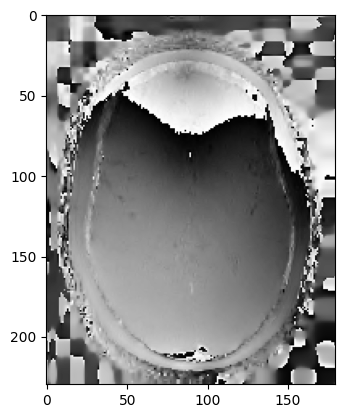

In [93]:
lamda = 0.005
img_l1wav = mr.app.L1WaveletRecon(ksp, mps, lamda).run()

pl.ImagePlot(img_l1wav, title='L1 Wavelet Regularized Reconstruction')
img_sense_32 = mr.app.SenseRecon(ksp, mps, lamda=lamda, solver='ConjugateGradient', max_iter=10).run()

plt.imshow(np.flip(np.angle(img_l1wav)), cmap='gray')

# Numpy L1 implementation

c:\Users\greno\Documents\Prog\MATH221\ma221_proj\venv\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Phase')

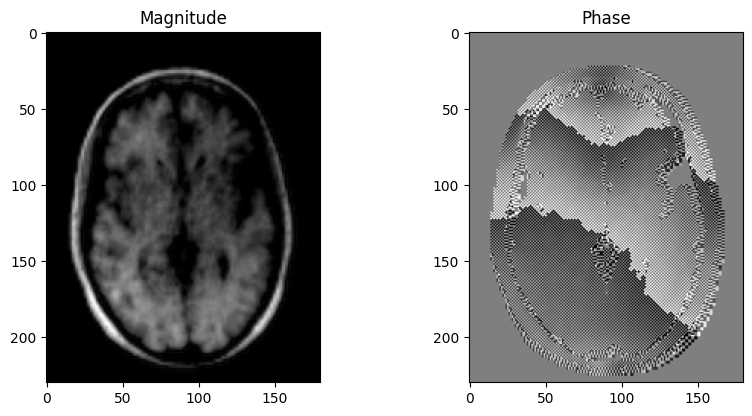

In [ ]:
# L1 Wavelet Reconstruction in numpy
def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def l1_sense_reconstruction(kspace, sensitivity_maps, num_iters=100, lamda=1e-2, tol=1e-6, use_fp16=False):
    ishape = (kspace.shape[1], kspace.shape[2]) # image shape
    
    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)
    
    W = get_weights(kspace)

    def forward_op(x):
        #return A(x)
        """Forward operation: SENSE forward model."""
        shifted_image = np.fft.fftshift(x*sensitivity_maps, axes=(-2,-1)) # need to shift
        res =  np.fft.fft2(shifted_image, ishape, norm='ortho', axes=(-2,-1))

        if use_fp16:
            res = to_fp16(res)
        
        return W**0.5 * res
    
    # x* FHSH
    def adjoint_op(y):
        #return A.H(y)
        """Adjoint operation: SENSE adjoint model."""
        ifft_result = np.fft.ifft2(W**0.5*y, ishape, norm='ortho',  axes=(-2,-1))
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(-2,-1)) # need to shift
        res = np.sum(np.conj(sensitivity_maps) * shifted_ifft_result, axis=0)

        if use_fp16:
            res = to_fp16(res)

        return res

    def soft_threshold(x, lamda):
        sign = np.where(np.abs(x) == 0, 0, x/np.abs(x))
        mag = np.abs(x) - lamda
        mag = (np.abs(mag) + mag)/2
        return sign * mag
    
    def g(x, alpha):
        
        # Wavelet transform
        ishape = x.shape
        zshape = [((i + 1) // 2) * 2 for i in x.shape]
        zinput = np.resize(x, zshape)
        coeffs = pywt.wavedecn(zinput, 'db4', mode='zero', axes=(-2,-1))
        w, coeff_slices = pywt.coeffs_to_array(coeffs, axes=(-2,-1))
        # proximal operator for L1 norm
        prox = soft_threshold(w, alpha*lamda)
        
        # Inverse Wavelet transform
        inv_input = pywt.array_to_coeffs(prox, coeff_slices, output_format='wavedecn')
        recn = pywt.waverecn(inv_input, 'db4', mode='zero', axes=(-2,-1))
        return recn

    # Define AHA operator: A^H A + lambda I
    def normal_op(x):
        #return x + lamda * x
        """Normal equation operator: A^H A + lambda L1 norm"""
        result = adjoint_op(forward_op(x)) + lamda*x

        if use_fp16:
            return to_fp16(result)
        
        return result
    
    b = adjoint_op(W**0.5 * kspace)
    x = np.zeros_like(b)  # 0s init
    r = np.zeros_like(b)  # 0s init

    alpha = 0.1
    # gradient descent iterations
    for i in range(num_iters):
        x_old = x.copy()

        if use_fp16:
            r = to_fp16(normal_op(x) - b + lamda*x)
        else:   
            r = normal_op(x) - b + lamda*x
        
        x = g(x - alpha * r, alpha)
        resid = np.linalg.norm(x-x_old)/alpha

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break
        

    return x


recon_img = l1_sense_reconstruction(ksp, mps, num_iters=100, lamda=0.005, use_fp16=False) 

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('Magnitude')
plt.subplot(222)
plt.imshow(np.angle(np.flip(recon_img)), cmap='gray')
plt.title('Phase')